### Bin population and flood point data into hex grid

- Create hex grid
- Areally interpolate the population data with the hex grid
- Bin the 311 flooding data into the hex grid and normalize using the the areally interpolated population data

In [1]:
import geopandas as gpd
import pyproj

from tobler.util import h3fy
import contextily as cx
import matplotlib.pyplot as plt
import numpy as np



#My conda environment points to the wrong database path so I need to fix this to be able to set the crs of my geodataframe
# print(pyproj.datadir.get_data_dir())
pyproj.datadir.set_data_dir('/usr/local/anaconda3/envs/info615/share/proj')

from IPython.core.pylabtools import figsize
figsize(10,10)


/usr/local/anaconda3/envs/info615/lib/python3.10/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


### Load block-level census data

In [2]:
pop_gdf = gpd.read_file('processed_data/nyc_block_population_2020.shp')
pop_gdf.head()

,cb2020,borocode,boroname,ct2020,bctcb2020,geoid,shape_leng,shape_area,GEO_ID,2020Pop,geometry
0,1000,1,Manhattan,000100,10001001000,360610001001000,6627.858318,1.204255e+06,1000000US360610001001000,0,"POLYGON ((-74.03995 40.70089, -74.03945 40.700..."
1,1001,1,Manhattan,000100,10001001001,360610001001001,4395.190183,6.401664e+05,1000000US360610001001001,0,"POLYGON ((-74.04388 40.69019, -74.04351 40.689..."
2,1000,1,Manhattan,000201,10002011000,360610002011000,1569.384823,1.292763e+05,1000000US360610002011000,801,"POLYGON ((-73.98511 40.71379, -73.98706 40.713..."
3,1001,1,Manhattan,000201,10002011001,360610002011001,1594.262855,1.393604e+05,1000000US360610002011001,0,"POLYGON ((-73.98506 40.71308, -73.98544 40.713..."
4,2000,1,Manhattan,000201,10002012000,360610002012000,2055.295961,2.633084e+05,1000000US360610002012000,1186,"POLYGON ((-73.98495 40.71236, -73.98485 40.711..."


In [3]:
#Double check
pop_gdf.crs

<Geographic 2D CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (Degree)
- lat[north]: Latitude (Degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [4]:
#Project to something that has reliable distance/area in NYC
pop_gdf = pop_gdf.to_crs(epsg=2263)

### Define the hex grid


In [5]:
# H3 needs a polygon as input, so use bounding box - needed to add a 1000 ft buffer to geometry to make sure hex grid extended far enough for tips of boroughs not to cut off a few
bounding_box = pop_gdf.dissolve().buffer(1000).envelope[0]
bounding_box = gpd.GeoDataFrame(geometry=[bounding_box])
bounding_box.crs = pop_gdf.crs

hex_grid = h3fy(bounding_box, resolution=9)
hex_grid.reset_index(inplace = True)


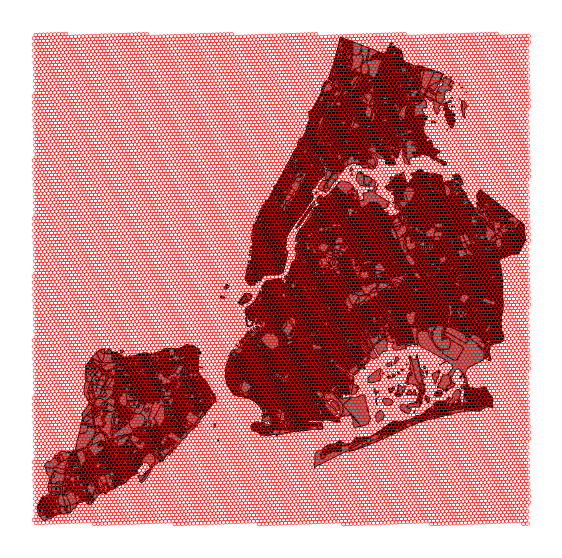

In [6]:
ax = pop_gdf.plot(facecolor='gray', edgecolor = 'black')
hex_grid.plot(ax = ax, facecolor='none', edgecolor='red', linewidth = .5)
# cx.add_basemap(ax, crs=pop_gdf.crs,source = cx.providers.CartoDB.DarkMatter)
ax.axis('off');

### Clip the hex grid with the shoreline

Data source: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

In [7]:
#Import borough boundaries 
borough_gdf = gpd.read_file('raw_data/Borough Boundaries/geo_export_1f0f1e34-b53d-4bba-9a46-60c7a408e3c5.shp')
borough_gdf = borough_gdf.to_crs(epsg=2263)
hex_grid = hex_grid.clip(borough_gdf.dissolve())

### Get everything in hex grid not in the park boundaries
Data source: https://data.cityofnewyork.us/Recreation/Open-Space-Parks-/g84h-jbjm

In [8]:
park_gdf = gpd.read_file('raw_data/Open Space (Parks)/geo_export_7183dcdf-74f8-429f-9cb1-b4563e89cf96.shp')
park_gdf = park_gdf.to_crs(epsg=2263)

hex_grid = hex_grid.difference(park_gdf.dissolve().geometry[0], align = False)

### Check results

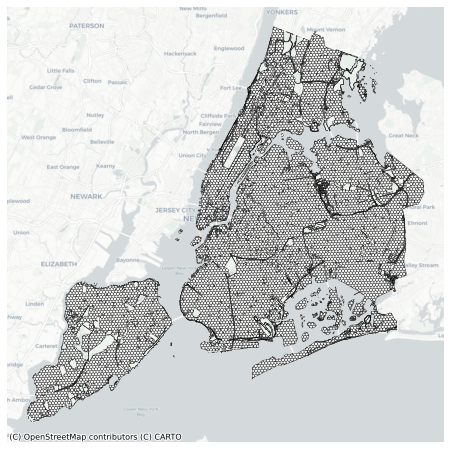

In [9]:
ax = hex_grid.to_crs(epsg=3857).plot(facecolor = 'white', alpha = .7, edgecolor='black', linewidth = .5, figsize=(12, 8))
cx.add_basemap(ax, source = cx.providers.CartoDB.Positron)
ax.axis('off');

In [10]:
#Drop empty geometries (ie. things completely in parks)
hex_grid = hex_grid[~(hex_grid.isna() | hex_grid.is_empty)]

/var/folders/x1/y94l059d54s9xkg8km690fd80000gn/T/ipykernel_24651/991881007.py:2: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  hex_grid = hex_grid[~(hex_grid.isna() | hex_grid.is_empty)]


### Calculate the area of each census block

In [11]:
pop_gdf['block_area_sq_ft'] = pop_gdf.area

## Areal interpolation to reaggregate population of blocks into hexagonal grid

In [12]:
hex_grid = hex_grid.reset_index()

In [13]:
hex_grid['hex_id_simple'] = range(hex_grid.shape[0])
hex_grid = gpd.GeoDataFrame(hex_grid[['index', 'hex_id_simple']], geometry = hex_grid[0], crs = 2263)
hex_grid.head()

,index,hex_id_simple,geometry
0,9164,0,"POLYGON ((946196.411 132141.420, 946190.845 13..."
1,14672,1,"POLYGON ((946769.167 132775.778, 946878.634 13..."
2,3458,2,"POLYGON ((946148.065 133714.236, 946749.510 13..."
3,10624,3,"POLYGON ((946749.510 133415.514, 947331.296 13..."
4,16334,4,"MULTIPOLYGON (((942517.962 133530.339, 942498...."


#### First merge
Create a dataframe where each row corresponds with a grid cell and a block that intersects with it (for all such pairs)

In [14]:
#Expect this to be larger than 37590 (size of hex grid) since some blocks intersect with multiple hex grids
hex_grid_merged_pop = hex_grid.sjoin(pop_gdf, predicate = 'intersects', how = 'inner')
print(hex_grid_merged_pop.shape)
hex_grid_merged_pop.head(2)

(85431, 15)


,index,hex_id_simple,geometry,index_right,cb2020,borocode,boroname,ct2020,bctcb2020,geoid,shape_leng,shape_area,GEO_ID,2020Pop,block_area_sq_ft
0,9164,0,"POLYGON ((946196.411 132141.420, 946190.845 13...",35052,1003,5,Staten Island,015400,50154001003,360850154001003,28876.690145,6.748847e+06,1000000US360850154001003,0,6.749020e+06
1,14672,1,"POLYGON ((946769.167 132775.778, 946878.634 13...",35052,1003,5,Staten Island,015400,50154001003,360850154001003,28876.690145,6.748847e+06,1000000US360850154001003,0,6.749020e+06


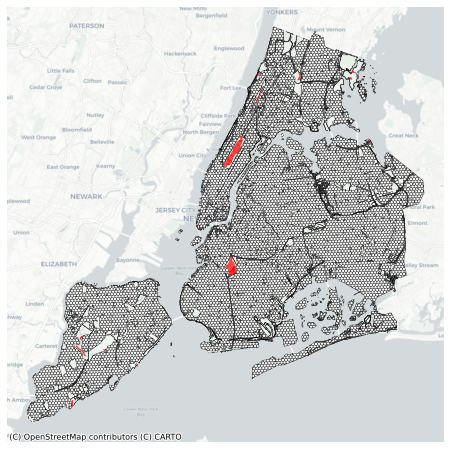

In [15]:
#Check - All blocks should show up at least once in the merged dataframe unless in a park
missing_blocks = list(set(range(37590)) - set(hex_grid_merged_pop['index_right'].unique()))

ax = hex_grid.to_crs(epsg=3857).plot(facecolor = 'white', alpha = .7, edgecolor='black', linewidth = .5, figsize=(12, 8))
pop_gdf.loc[missing_blocks, :].to_crs(epsg=3857).plot(ax=ax, facecolor = 'red', alpha = .7, edgecolor='red', linewidth = .5, figsize=(12, 8))

cx.add_basemap(ax, source = cx.providers.CartoDB.Positron)
ax.axis('off');

#### Calculate the percent of block that falls within the hex grid specified in that row

In [16]:
def calc_intersecting_area(row, pop_gdf):
    hex_geom = row['geometry']
    block_geom = pop_gdf.loc[row['index_right'], 'geometry']
    return hex_geom.intersection(block_geom).area

hex_grid_merged_pop['intersecting_area'] = hex_grid_merged_pop.apply(lambda row: calc_intersecting_area(row, pop_gdf = pop_gdf), axis = 1)
hex_grid_merged_pop['perc_block_in_hex_grid'] = hex_grid_merged_pop['intersecting_area']/hex_grid_merged_pop['block_area_sq_ft']*100


In [17]:
hex_grid_merged_pop['perc_block_in_hex_grid'].describe()

count    8.543100e+04
mean     4.228912e+01
std      3.582507e+01
min      1.704344e-08
25%      8.116487e+00
50%      3.367336e+01
75%      7.532153e+01
max      1.000000e+02
Name: perc_block_in_hex_grid, dtype: float64

#### Use percent to calculate the population contributed to each the hex grid by the block specified in that row

In [18]:
hex_grid_merged_pop['pop_contribution_from_block'] = hex_grid_merged_pop['perc_block_in_hex_grid']*hex_grid_merged_pop['2020Pop']

In [19]:
#Check - The number of blocks that intersect with each hex grid
hex_grid_merged_pop.groupby('hex_id_simple')['2020Pop'].count()

hex_id_simple
0        2
1        1
2        2
3        1
4        2
        ..
8216    10
8217     1
8218     5
8219     1
8220     2
Name: 2020Pop, Length: 8221, dtype: int64

#### Sum population contributions from all blocks intersecting with a hex to get population in that hex grid

In [20]:
hex_grid_with_pop = hex_grid_merged_pop.groupby('hex_id_simple')['pop_contribution_from_block'].sum().reset_index()
hex_grid_with_pop.rename(columns = {'pop_contribution_from_block':'2020PopEstimate'}, inplace = True)

In [21]:
hex_grid_with_pop.head()

,hex_id_simple,2020PopEstimate
0,0,0.00000
1,1,0.00000
2,2,0.00000
3,3,0.00000
4,4,129.14586


#### Final merge to recover data dropped in the groupby 

In [22]:
hex_with_pop_gdf = hex_grid.merge(hex_grid_with_pop, on = 'hex_id_simple')

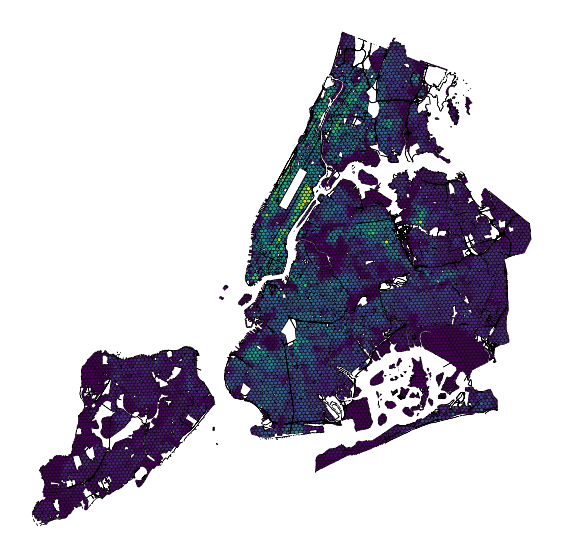

In [23]:
ax = hex_with_pop_gdf.plot(column = '2020PopEstimate', edgecolor='black', linewidth = .5)
# cx.add_basemap(ax, crs=pop_gdf.crs,source = cx.providers.CartoDB.DarkMatter)
ax.axis('off');

### 311 point aggregation with hexagonal grid

In [24]:
flood_gdf = gpd.read_file('processed_data/311_flooding.geojson')
flood_gdf.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type,created_year,geometry
0,50721977,2021-05-30T11:07:00,2021-05-30T11:10:00,DEP,Department of Environmental Protection,SEWER,CATCH BASIN CLOGGED/FLOODING (USE COMMENTS) (SC),11223,50 AVENUE V,AVENUE V,...,40.593772,-73.982594,None,None,None,None,None,None,2021,POINT (-73.98259 40.59377)
1,50462778,2021-05-03T10:24:00,2021-05-04T10:35:00,DEP,Department of Environmental Protection,SEWER,CATCH BASIN CLOGGED/FLOODING (USE COMMENTS) (SC),11235,2558 EAST 19 STREET,EAST 19 STREET,...,40.589305,-73.950728,None,None,None,None,None,None,2021,POINT (-73.95073 40.58931)
2,50465700,2021-05-04T14:59:00,2021-05-05T08:10:00,DEP,Department of Environmental Protection,SEWER,CATCH BASIN CLOGGED/FLOODING (USE COMMENTS) (SC),11361,43-03 223 STREET,223 STREET,...,40.762656,-73.758667,None,None,None,None,None,None,2021,POINT (-73.75867 40.76266)
3,50465779,2021-05-04T17:58:00,2021-05-05T07:15:00,DEP,Department of Environmental Protection,SEWER,STREET FLOODING (SJ),11226,2225 TILDEN AVENUE,TILDEN AVENUE,...,40.646608,-73.956296,None,None,None,None,None,None,2021,POINT (-73.95630 40.64661)
4,45123767,2019-12-10T14:09:00,2019-12-10T14:20:00,DEP,Department of Environmental Protection,SEWER,CATCH BASIN CLOGGED/FLOODING (USE COMMENTS) (SC),11432,186-06 HILLSIDE AVENUE,HILLSIDE AVENUE,...,40.714542,-73.775914,None,None,None,None,None,None,2019,POINT (-73.77591 40.71454)


In [25]:
flood_gdf = flood_gdf.to_crs(epsg = 2263)

#### Calculate the number of flooding complaints per hex grid cell


In [26]:
def rasterize(gdf, grid, aggfunc="count", column=None, plot=True):
    merged = gpd.sjoin(gdf, grid, how='left', predicate='within').copy()
    if aggfunc == "count":
        column = 'count'
        output_col = column
        merged[column] = 1
    else:
        output_col = column + "_" + aggfunc   
    dissolved = merged.dissolve(by="index_right", aggfunc=aggfunc)[[column]]
    dissolved.columns = [output_col]
    grid.loc[dissolved.index, output_col] = dissolved[output_col].values
    grid[output_col] = grid[output_col].fillna(0)
    if plot:
        ax = grid.plot(column=output_col, figsize=(12, 8), edgecolor="grey", legend=True, linewidth = .01)
        ax.axis('off')
#         cx.add_basemap(ax,source=cx.providers.CartoDB.DarkMatter,crs=gdf.crs)
        plt.show()
    return grid

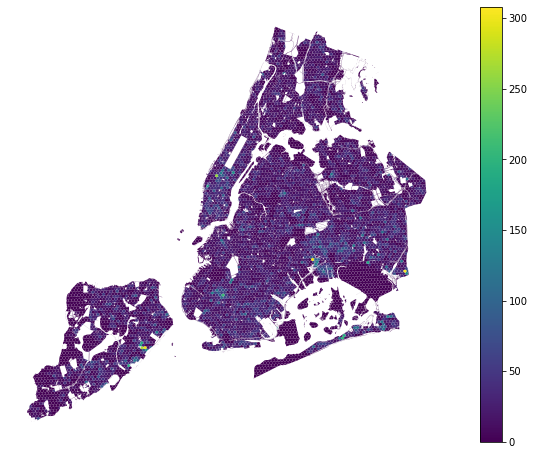

In [27]:
hex_with_flood_counts_gdf = rasterize(gdf = flood_gdf, grid = hex_grid)

### Merge the number of flooding complaints with the number of people in each hex grid

In [28]:
hex_gdf = hex_with_flood_counts_gdf.merge(hex_with_pop_gdf.drop(columns = ['geometry', 'index']), on = 'hex_id_simple')
hex_gdf.rename(columns = {'count':'num_311_complaints'}, inplace = True)
hex_gdf.head()

,index,hex_id_simple,geometry,num_311_complaints,2020PopEstimate
0,9164,0,"POLYGON ((946196.411 132141.420, 946190.845 13...",0.0,0.00000
1,14672,1,"POLYGON ((946769.167 132775.778, 946878.634 13...",0.0,0.00000
2,3458,2,"POLYGON ((946148.065 133714.236, 946749.510 13...",0.0,0.00000
3,10624,3,"POLYGON ((946749.510 133415.514, 947331.296 13...",0.0,0.00000
4,16334,4,"MULTIPOLYGON (((942517.962 133530.339, 942498....",0.0,129.14586


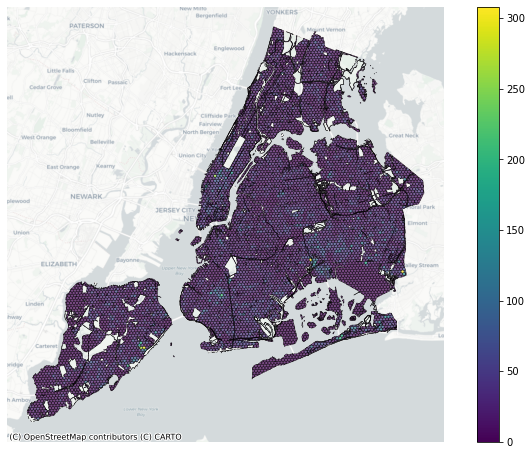

In [29]:
ax = hex_gdf.to_crs(epsg=3857).plot(column = 'num_311_complaints', alpha = .7, edgecolor='black', linewidth = .5, figsize=(12, 8), legend = True)
cx.add_basemap(ax, source = cx.providers.CartoDB.Positron)
ax.axis('off');

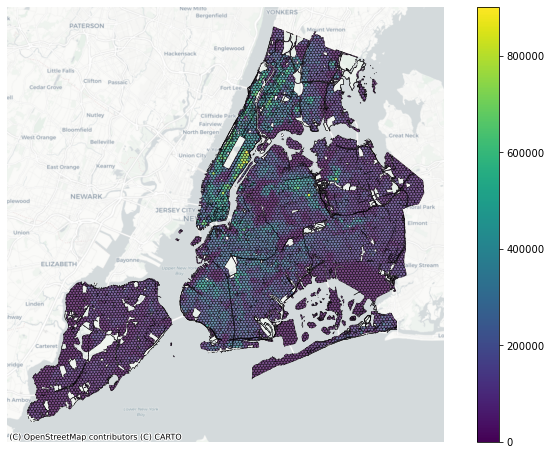

In [30]:
ax = hex_gdf.to_crs(epsg=3857).plot(column = '2020PopEstimate', alpha = .7, edgecolor='black', linewidth = .5, figsize=(12, 8), legend = True)
cx.add_basemap(ax, source = cx.providers.CartoDB.Positron)
ax.axis('off');

### Normalize flooding counts by population in hex grid cell
Complaints per 10000 people

In [31]:
#Create version of pop column where 0 pop is np.nan so that we don't end up with infinity
hex_gdf['2020PopEstimate_adj']  = hex_gdf['2020PopEstimate'].replace(0, np.nan)
hex_gdf['num_311_complaints_norm'] = hex_gdf['num_311_complaints']/hex_gdf['2020PopEstimate_adj']*10000

count    960.000000
mean       0.254167
std        1.811786
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       36.000000
Name: num_311_complaints, dtype: float64

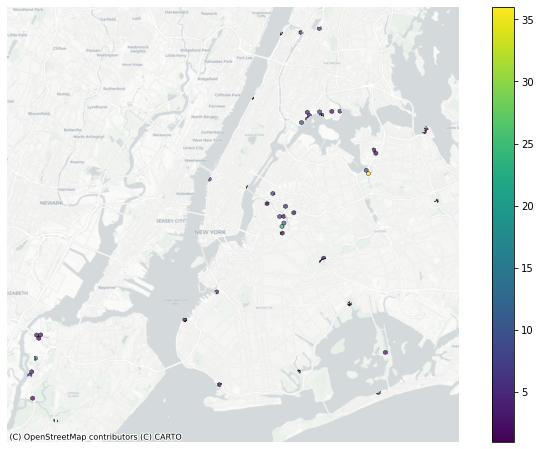

In [32]:
#Check - Do any of the ones with no population have lots of complaints? - yes, but not a ton
no_pop = hex_gdf[hex_gdf['num_311_complaints_norm'].isna()]
display(no_pop['num_311_complaints'].describe())

no_pop_with_complaints = no_pop[no_pop['num_311_complaints'] > 0]

ax = no_pop_with_complaints.to_crs(epsg=3857).plot(column = 'num_311_complaints', alpha = .7, edgecolor='black', linewidth = .5, figsize=(12, 8), legend = True)
cx.add_basemap(ax, source = cx.providers.CartoDB.Positron)
ax.axis('off');

In [34]:
hex_gdf.to_file('processed_data/complaints_per_10000_people.geojson', driver = 'GeoJSON')

/usr/local/anaconda3/envs/info615/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### Filter to the ones that have nonzero populations


In [35]:
#Of the hexagons with people, how many people do they typically have?
hex_nonzero_pop_gdf = hex_gdf[hex_gdf['2020PopEstimate'] != 0]
hex_nonzero_pop_gdf['2020PopEstimate'].describe()

count      7261.000000
mean     119814.446956
std      131693.195966
min           0.000059
25%       17786.204219
50%       76631.017612
75%      180904.233642
max      901288.542545
Name: 2020PopEstimate, dtype: float64

### Drop some of the population outliers that are driving high outliers of counts per 10,000 people

In [36]:
#Drop the ones below the 10% percentile
print(hex_nonzero_pop_gdf['2020PopEstimate'].quantile(.1))
hex_pruned_gdf = hex_nonzero_pop_gdf[hex_nonzero_pop_gdf['2020PopEstimate'] > hex_nonzero_pop_gdf['2020PopEstimate'].quantile(.1)]
hex_pruned_gdf.to_file('processed_data/complaints_per_10000_people_zero_and_low_pop_outliers_lt10_dropped.geojson')

252.20735292152645


/usr/local/anaconda3/envs/info615/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [37]:
#Drop the ones below the 5 percentile (95% of the hex grid cells have more than 27 people in them - these outliers will mess with results)
hex_pruned_gdf = hex_nonzero_pop_gdf[hex_nonzero_pop_gdf['2020PopEstimate'] > hex_nonzero_pop_gdf['2020PopEstimate'].quantile(.05)]
hex_pruned_gdf.to_file('processed_data/complaints_per_10000_people_zero_and_low_pop_outliers_lt5_dropped.geojson')

/usr/local/anaconda3/envs/info615/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [38]:
hex_pruned_gdf['num_311_complaints_norm'].describe()

count    6897.000000
mean        9.811933
std       110.336564
min         0.000000
25%         0.381431
50%         1.193098
75%         3.115032
max      3534.832482
Name: num_311_complaints_norm, dtype: float64